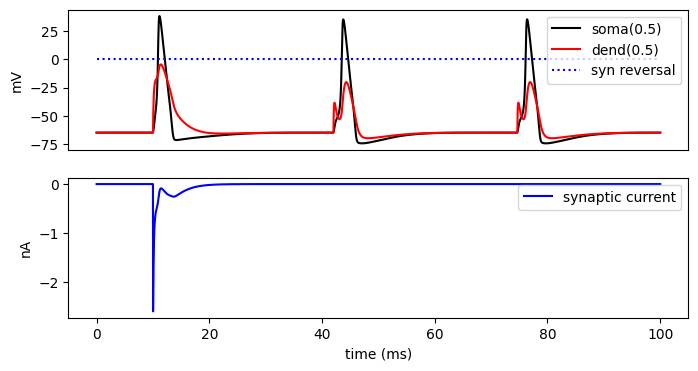

In [10]:
from neuron import h, gui
from neuron.units import ms, mV
import matplotlib.pyplot as plt

%matplotlib inline

def main() -> None:
    my_cells = create_n_BallAndStick(7, 50)
    ps = h.PlotShape(True)
    ps.show(0)
    my_cells = create_n_BallAndStick(5, 50)
    h.load_file('stdrun.hoc')
    stim = h.NetStim() # Make a new stimulator

    # Attach it to a synapse in the middle of the dendrite
    # of the first cell in the network. (Named 'syn_' to avoid
    # being overwritten with the 'syn' var assigned later.)
    syn_ = h.ExpSyn(my_cells[0].dend(0.5))
    syn_i = h.Vector().record(syn_._ref_i)

    stim.number = 1
    stim.start = 9
    ncstim = h.NetCon(stim, syn_)
    ncstim.delay = 1 * ms
    ncstim.weight[0] = 0.04 # NetCon weight is a vector.
    syn_.tau = 2 * ms

    recording_cell = my_cells[0]
    soma_v = h.Vector().record(recording_cell.soma(0.5)._ref_v)
    dend_v = h.Vector().record(recording_cell.dend(0.5)._ref_v)
    t = h.Vector().record(h._ref_t)
    
    syns = []
    netcons = []
    for source, target in zip(my_cells, my_cells[1:] + [my_cells[0]]):
        syn = h.ExpSyn(target.dend(0.5))
        nc = h.NetCon(source.soma(0.5)._ref_v, syn, sec=source.soma)
        nc.weight[0] = 0.05
        nc.delay = 5
        netcons.append(nc)
        syns.append(syn)

    h.finitialize(-65 * mV)
    h.continuerun(100 * ms)
        
    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(2, 1, 1)
    soma_plot = ax1.plot(t, soma_v, color='black', label='soma(0.5)')
    dend_plot = ax1.plot(t, dend_v, color='red', label='dend(0.5)')
    rev_plot = ax1.plot([t[0], t[-1]], [syn_.e, syn_.e], label='syn reversal',
            color='blue', linestyle=':')
    ax1.legend()
    ax1.set_ylabel('mV')
    ax1.set_xticks([]) # Use ax2's tick labels

    ax2 = fig.add_subplot(2, 1, 2)
    syn_plot = ax2.plot(t, syn_i, color='blue', label='synaptic current')
    ax2.legend()
    ax2.set_ylabel(h.units('ExpSyn.i'))
    ax2.set_xlabel('time (ms)')
    plt.show()

def create_n_BallAndStick(n, r):
    """n = number of cells; r = radius of circle"""
    cells = []
    for i in range(n):
        theta = i * 2 * h.PI / n
        cells.append(BallAndStick(i, h.cos(theta) * r, h.sin(theta) * r, 0, theta))
    return cells    

class Cell:
    def __init__(self, gid, x, y, z, theta):
        self._gid = gid
        self._setup_morphology()
        self.all = self.soma.wholetree()
        self._setup_biophysics()
        self.x = self.y = self.z = 0     
        h.define_shape()
        self._rotate_z(theta)                                   
        self._set_position(x, y, z) 
    def __repr__(self):
        return '{}[{}]'.format(self.name, self._gid)
    def _set_position(self, x, y, z):
        for sec in self.all:
            for i in range(sec.n3d()):
                sec.pt3dchange(i,
                               x - self.x + sec.x3d(i),
                               y - self.y + sec.y3d(i),
                               z - self.z + sec.z3d(i),
                              sec.diam3d(i))
        self.x, self.y, self.z = x, y, z
    def _rotate_z(self, theta):
        """Rotate the cell about the Z axis."""
        for sec in self.all:
            for i in range(sec.n3d()):
                x = sec.x3d(i)
                y = sec.y3d(i)
                c = h.cos(theta)
                s = h.sin(theta)
                xprime = x * c - y * s
                yprime = x * s + y * c
                sec.pt3dchange(i, xprime, yprime, sec.z3d(i), sec.diam3d(i))

class BallAndStick(Cell):
    name = 'BallAndStick'
    def _setup_morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
        self.dend.connect(self.soma)
        self.soma.L = self.soma.diam = 12.6157
        self.dend.L = 200
        self.dend.diam = 1
    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
        self.soma.insert('hh')                                          
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003    # Leak conductance in S/cm2
            seg.hh.el = -54.3     # Reversal potential in mV
        # Insert passive current in the dendrite
        self.dend.insert('pas')                 
        for seg in self.dend:
            seg.pas.g = 0.001  # Passive conductance in S/cm2
            seg.pas.e = -65    # Leak reversal potential mV

mycell = BallAndStick(0, 0, 0, 0, 0)

main()